In [1]:
!pip3 install sklearn
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import learning_curve
#from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os
import re
import csv
import glob

In [3]:
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|※|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|：|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

data kakunou

In [4]:
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
#target_genre = ["dokujo-tsushin", "it-life-hack"] 
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1712, 4)


,media_name,label,title,sentence
1328,peachy,1,終了しました白金のシンボル的レストランBLUEPOINTのペアディナーチケット1ドリンク付き...,都内屈指の高級住宅街のひとつ、白金エリア。1990年代後半に登場したシロガネーゼという言葉の...
969,peachy,1,気分で着せ替え！今年の夏はスマホカバーで差をつけるスマホ女子特集後,お洋服を着替えるように、スマホも着せ替えしませんか？梅雨の合間にも、真夏の暑さを感じさせる今...
1594,peachy,1,2ヶ月間集中！ヘルスケアダイエットプロジェクトを応援してQUOカードをゲット,パナソニックが行なっている2ヶ月間集中！ヘルスケアダイエットプロジェクト。この企画では、全国...
347,dokujo-tsushin,0,オトナ女子たちの圧倒的支持をうけ、ドラマ10はつ恋の一挙再放送が決定,昨年女児を出産した女優の木村佳乃さんが2年ぶりに連ドラ主演を務め、現在NHK総合テレビで毎週...
1006,peachy,1,がんばる女子はどんな音楽の聞き方をしている,今年は、女子サッカーワールドカップでのなでしこジャパン優勝や、バレーボール世界選手権での女子...
1685,peachy,1,劇場版東京ガールズコレクションが、収益の一部を被災地に寄,"観客約2万3,000人を動員した東京ガールズコレクション。日本の誇るべきファッションカルチャ..."
803,dokujo-tsushin,0,40代女子はありかナシか,ツヤっと輝く、40代女子力というコンセプトを引っさげたファッション誌GLOWグローの創刊から...
1113,peachy,1,TGCモデルが集結！ブログポータルTokyogirlsblogオープ,史上最大級のファッションフェスタ東京ガールズコレクション以下、TGC出演の人気モデルやブラン...
1335,peachy,1,愛される為に知るべき男心アソコをさするだけの美容法などみんなのお気に入り登録記事ランキン,Peachyアプリを利用している皆さま、アプリのお気に入り機能は使っていますか？お気に入りと...
730,dokujo-tsushin,0,処世術はSMに学べ,先日、異業種交流女子会と称し、バリキャリ女子で集まった時の話。秘書室勤務のカオルさん33歳が...


In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

In [7]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になったことを機に働き方を変えたのだが、以降、仕事や人間関係がうまく築けずに悩み続けている。同時に、現在結婚していないことで将来に大きな不安も抱いている。この先、希望を見出すことは出来るのだろうか？霊感鑑定で定評のある占い師翔生先生に鑑定してもらった。占い師翔生先生nifty電話占いメール占い相談内容母の介護が必要になった頃から今までずっと社会から離れ、自宅にこもっているような状態が続いています。母は5年前に亡くなったのですが、それ以前から現在まで時、バイトなどをしているだけで、仕事が決まっても内容が合わなかったり、内定後、仕事先に行ってみると社内の雰囲気が悪かったりと長くは続かず、短期派遣を時折していました。しかし最近は、派遣の仕事さえも決まらず家にずっといるだけの状態になっています。父も高齢になってきており、一人っ子のため、先の事を考えると不安になります。友人も結婚したり、地方に引越したりと付き合いも無くなってきており、母の知人や派遣先で知り合った知人達とはメールでの連絡はとっていたのですが、最近はそんなメールも中止して欲しいと連絡してしまいました。親しくしていた母の親戚とも葬儀後、距離が出てしまい、父方の親戚とも連絡をとっていないため、先の事を考えると本当に不安です。こんな状況がずっと続いているのですが、今後、運命が変わる時は訪れるのでしょうか？鑑定結果はじめましてミミさん。占い師の翔生と申します。早速鑑定してみましょう。2007年の頃よりずっと、あなたは閉鎖的になってしまったようですね。これまでのあなたの努力は、誰にも真似できないほど頑張っていたに違いありません。お母様は深く感謝しておられます。お母様が今でもあなたに感謝しているのはあなたの努力あっての事とお察しします。その当時のあなたはとても精神的に辛く、肉体的にも疲れていた事でしょう。肉親との別れもあって、精神的に燃え尽きてしまった感触があります。その結果、誰かに意見されても、頑張ってきたという気持ちがあるせいか、周りの意見を遮断してしまいがちです。指図されたくない感情の方が優先されてしまうこれからの方向性にも、運勢上その傾向

In [8]:
sents = []

for i in range(df.shape[0]):
    sents.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[i])))

#print(sents)
sents = pd.DataFrame(sents)
print(type(sents))

<class 'pandas.core.frame.DataFrame'>


In [9]:
X_train, X_test, y_train, y_test = train_test_split(sents, labels, test_size=0.97, random_state=42, shuffle=True)

In [25]:
type(X_train)

pandas.core.frame.DataFrame

In [11]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=50, num_iterations=50)
eval_res = {}
lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)

[5]	training's binary_logloss: 0.58207	valid_0's binary_logloss: 0.661471
[10]	training's binary_logloss: 0.514869	valid_0's binary_logloss: 0.653957
[15]	training's binary_logloss: 0.460981	valid_0's binary_logloss: 0.650176
[20]	training's binary_logloss: 0.41617	valid_0's binary_logloss: 0.652522
[25]	training's binary_logloss: 0.376808	valid_0's binary_logloss: 0.654726
[30]	training's binary_logloss: 0.343573	valid_0's binary_logloss: 0.662192
[35]	training's binary_logloss: 0.31251	valid_0's binary_logloss: 0.664406
[40]	training's binary_logloss: 0.28622	valid_0's binary_logloss: 0.671549
[45]	training's binary_logloss: 0.262414	valid_0's binary_logloss: 0.675471
[50]	training's binary_logloss: 0.240775	valid_0's binary_logloss: 0.680131


LGBMClassifier(max_depth=50, num_iterations=50)

In [12]:
y_tra_pred = lgb_clf.predict(X_train)
print('Accuracy score = \t {}'.format(accuracy_score(y_train, y_tra_pred)))
print('Precision score = \t {}'.format(precision_score(y_train, y_tra_pred)))
print('Recall score =   \t {}'.format(recall_score(y_train, y_tra_pred)))
print('F1 score =      \t {}'.format(f1_score(y_train, y_tra_pred)))

Accuracy score = 	 1.0
Precision score = 	 1.0
Recall score =   	 1.0
F1 score =      	 1.0


In [18]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869
1267,9,14787,7,24,22.0,294.0,2304.0,1069.0,10.0,5186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1590,9,25986,28,438,4993.0,12.0,996.0,201.0,4366.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562,9,4427,30227,12,589.0,35.0,24464.0,4791.0,1521.0,2617.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1666,1644,9318,855,1253,13582.0,162.0,1718.0,22672.0,457.0,774.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,9,12400,7541,208,7.0,399.0,4513.0,7541.0,60.0,4988.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957,9,3178,1537,10,17435.0,7.0,1070.0,698.0,12.0,10781.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,9,612,49,3320,280.0,11.0,7.0,612.0,27.0,3972.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
975,9,14066,26,232,21156.0,12.0,20471.0,3176.0,7.0,4794.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699,4372,4003,6805,28,1656.0,30.0,15626.0,95.0,3427.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1499,9,189,182,789,17.0,189.0,182.0,3963.0,179.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
y_pred = lgb_clf.predict(X_test)
print('Accuracy score = \t {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score = \t {}'.format(precision_score(y_test, y_pred)))
print('Recall score =   \t {}'.format(recall_score(y_test, y_pred)))
print('F1 score =      \t {}'.format(f1_score(y_test, y_pred)))

Accuracy score = 	 0.600842865743528
Precision score = 	 0.5880281690140845
Recall score =   	 0.6162361623616236
F1 score =      	 0.6018018018018019


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

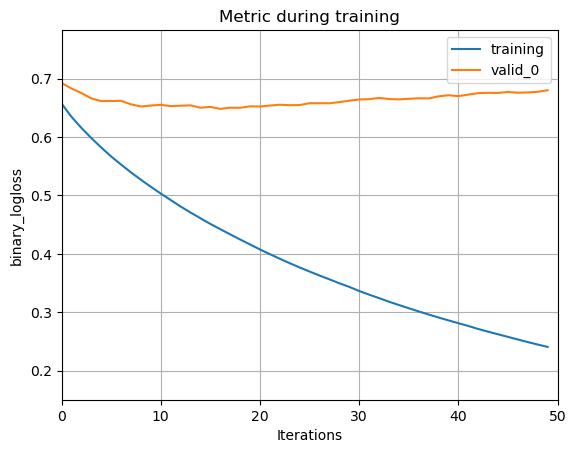

In [15]:
lightgbm.plot_metric(lgb_clf)

In [16]:
'''
# https://panda-clip.com/learning-curve/

train_sizes, train_scores, valid_scores = learning_curve(
                                              linear_model.Ridge(alpha=10),
                                              X=X_train.values, y=y_train,
                                              train_sizes=np.linspace(0.1, 1.0, 10),
                                              cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
'''

'\n# https://panda-clip.com/learning-curve/\n\ntrain_sizes, train_scores, valid_scores = learning_curve(\n                                              linear_model.Ridge(alpha=10),\n                                              X=X_train.values, y=y_train,\n                                              train_sizes=np.linspace(0.1, 1.0, 10),\n                                              cv=5)\n\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std  = np.std(train_scores, axis=1)\nvalid_mean = np.mean(valid_scores, axis=1)\nvalid_std  = np.std(valid_scores, axis=1)\n'

tonndemonaine

In [17]:
import pickle
with open('LGBMmodel.pickle', mode='wb') as fp:
    pickle.dump(lgb_clf, fp)